# National Flood Insurance Program Data for NYC
## Cover Photo

In [1]:
# importing libraries
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import urllib
import urllib.request
import requests
import matplotlib.patches as mpatches

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

In [2]:
print('printing packages and versions:\n')

%reload_ext watermark
%watermark -v -p numpy,pandas,geopandas,matplotlib,seaborn

printing packages and versions:

Python implementation: CPython
Python version       : 3.8.13
IPython version      : 8.4.0

numpy     : 1.23.1
pandas    : 1.4.3
geopandas : 0.11.1
matplotlib: 3.5.2
seaborn   : 0.11.2



In [3]:
# importing borough boundaries
path = 'https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile'
borough_gdf = gpd.read_file(path)
borough_gdf = borough_gdf.to_crs(2263)

# preview data
print('shape of data: {}'.format(borough_gdf.shape))
borough_gdf.head()

shape of data: (5, 5)


,boro_code,boro_name,shape_area,shape_leng,geometry
0,5.0,Staten Island,1.623621e+09,325917.353950,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
1,2.0,Bronx,1.187175e+09,463179.772813,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."
2,4.0,Queens,3.041419e+09,888199.730955,"MULTIPOLYGON (((1032452.015 154469.237, 103245..."
3,1.0,Manhattan,6.365205e+08,357713.308660,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
4,3.0,Brooklyn,1.934138e+09,728148.532410,"MULTIPOLYGON (((1022227.320 152028.146, 102207..."


<AxesSubplot:>

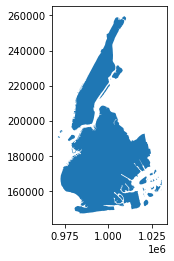

In [4]:
borough_gdf = (
    borough_gdf
    .loc[borough_gdf['boro_name'].isin(['Manhattan', 'Brooklyn'])]
    .reset_index(drop=True)
)

borough_gdf.plot()

In [5]:
# url path from the web
url = 'https://msc.fema.gov/portal/downloadProduct?productID=360497_PRELIMDB'
file = 'data/fema-pfirm.zip'

# download to data/ folder
urllib.request.urlretrieve(url, file)

%ls data/

claims-36005.json    fema-pfirm.zip       policies-36047.json
claims-36047.json    policies-1    .json  policies-36061.json
claims-36061.json    policies-1.json      policies-36081.json
claims-36081.json    policies-10000.json  policies-36085.json
claims-36085.json    policies-36005.json  policies-None.json


In [6]:
# reading in shape file
path = 'data/fema-pfirm.zip!s_fld_haz_ar.shp'
pfirm_gdf = gpd.read_file(path)

# examine data
print('shape of data: {}'.format(pfirm_gdf.shape))
pfirm_gdf.head()

shape of data: (3985, 15)


,FLD_AR_ID,FLD_ZONE,FLOODWAY,SFHA_TF,STATIC_BFE,V_DATUM,DEPTH,LEN_UNIT,VELOCITY,VEL_UNIT,AR_REVERT,BFE_REVERT,DEP_REVERT,SOURCE_CIT,geometry
0,81,AE,None,T,13.0,NAVD88,-9999.0,FEET,-9999.0,None,None,-9999.0,-9999.0,STUDY4,"POLYGON ((1032001.691 263867.839, 1032006.047 ..."
1,82,X,None,F,-9999.0,None,-9999.0,None,-9999.0,None,None,-9999.0,-9999.0,STUDY4,"POLYGON ((1033748.952 263778.464, 1033752.656 ..."
2,83,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,-9999.0,None,-9999.0,None,-9999.0,None,None,-9999.0,-9999.0,STUDY4,"POLYGON ((1033309.701 263544.181, 1033322.210 ..."
3,84,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,-9999.0,None,-9999.0,None,-9999.0,None,None,-9999.0,-9999.0,STUDY4,"POLYGON ((1033414.148 262658.868, 1033414.934 ..."
4,85,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,-9999.0,None,-9999.0,None,-9999.0,None,None,-9999.0,-9999.0,STUDY4,"POLYGON ((1034089.115 262466.034, 1034089.402 ..."


In [7]:
if pfirm_gdf.crs is None:
    # manually set crs to 2263
    pfirm_gdf = pfirm_gdf.set_crs(2263)
    
pfirm_gdf.crs

<Derived Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [8]:
condition = (
    (pfirm_gdf['SFHA_TF'] == 'T')
    | (pfirm_gdf['FLD_ZONE'] == '0.2 PCT ANNUAL CHANCE FLOOD HAZARD')
)

pfirm_gdf = pfirm_gdf.loc[condition]

pfirm_gdf.head()

,FLD_AR_ID,FLD_ZONE,FLOODWAY,SFHA_TF,STATIC_BFE,V_DATUM,DEPTH,LEN_UNIT,VELOCITY,VEL_UNIT,AR_REVERT,BFE_REVERT,DEP_REVERT,SOURCE_CIT,geometry
0,81,AE,None,T,13.0,NAVD88,-9999.0,FEET,-9999.0,None,None,-9999.0,-9999.0,STUDY4,"POLYGON ((1032001.691 263867.839, 1032006.047 ..."
2,83,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,-9999.0,None,-9999.0,None,-9999.0,None,None,-9999.0,-9999.0,STUDY4,"POLYGON ((1033309.701 263544.181, 1033322.210 ..."
3,84,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,-9999.0,None,-9999.0,None,-9999.0,None,None,-9999.0,-9999.0,STUDY4,"POLYGON ((1033414.148 262658.868, 1033414.934 ..."
4,85,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,-9999.0,None,-9999.0,None,-9999.0,None,None,-9999.0,-9999.0,STUDY4,"POLYGON ((1034089.115 262466.034, 1034089.402 ..."
5,86,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,-9999.0,None,-9999.0,None,-9999.0,None,None,-9999.0,-9999.0,STUDY4,"POLYGON ((1033316.808 262437.816, 1033316.108 ..."


<AxesSubplot:>

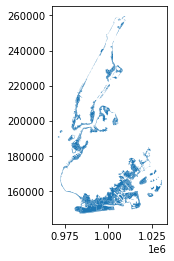

In [9]:
# clip flood polygon against borough geometry
clipped_pfirm = gpd.clip(pfirm_gdf, borough_gdf)

clipped_pfirm.plot()

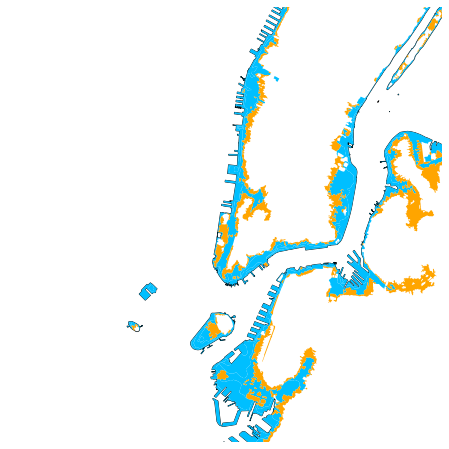

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))

colors = ['deepskyblue', 'orange']
zones = [['VE', 'AE', 'A', 'AO'], ['0.2 PCT ANNUAL CHANCE FLOOD HAZARD']]

for zone, color in zip(zones, colors):
    
    (clipped_pfirm
     .loc[clipped_pfirm['FLD_ZONE'].isin(zone)]
     .plot(color=color, ax=ax)
    )


borough_gdf.plot(
    ax=ax,
    facecolor='None',
    zorder=0,
    linewidth=.7
)

plt.ylim(180000, 220000)
plt.xlim(960000, 1000000)
plt.axis('off')
plt.savefig('figures/cover-photo.png', bbox_inches='tight', dpi=250)